# Some example of caluations with quaternions

Import some modules. DefDAP can be downloaded from here: https://github.com/MechMicroMan/DefDAP. As of 28/02/2019 you will need to install from the develop branch
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import defdap.ebsd as ebsd
from defdap.quat import Quat

%matplotlib inline

## Calculate misorientation

In [2]:
eulers1 = [45., 30., 30.]
eulers2 = [45., 30., 50.]
eulers1 = np.array(eulers1) * np.pi / 180
eulers2 = np.array(eulers2) * np.pi / 180
q1 = Quat.fromEulerAngles(*eulers1)
q2 = Quat.fromEulerAngles(*eulers2)

In [3]:
misori = 2*np.arccos(q1.dot(q2))

print(round(misori*180/np.pi, 1), 'deg')

20.0 deg


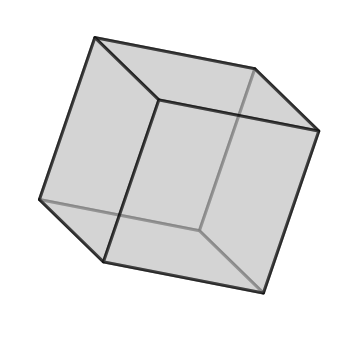

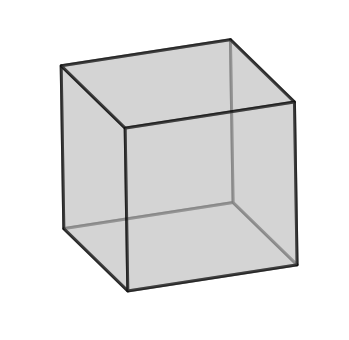

In [4]:
q1.plotUnitCell(symGroup='cubic')
q2.plotUnitCell(symGroup='cubic')

### Calculate misorientation considering the symmetric equivalent orientations

In [5]:
eulers3 = [1., 112.,  70.]
eulers3 = np.array(eulers3) * np.pi / 180
q3 = Quat.fromEulerAngles(*eulers3)

In [6]:
misori = 2*np.arccos(q2.dot(q3))

print(round(misori*180/np.pi, 1), 'deg')

89.5 deg


In [7]:
misori = 2*np.arccos(q2.misOri(q3, 'cubic'))

print(round(misori*180/np.pi, 1), 'deg')

0.6 deg


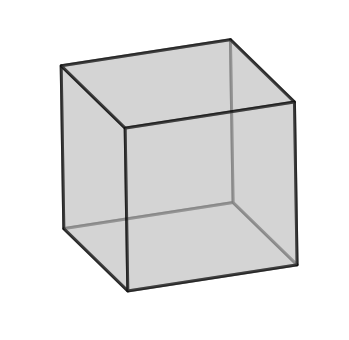

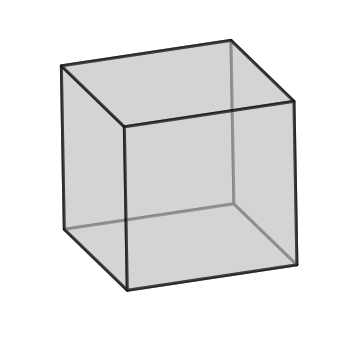

In [8]:
q2.plotUnitCell(symGroup='cubic')
q3.plotUnitCell(symGroup='cubic')

### Plot orientaions on an IPF

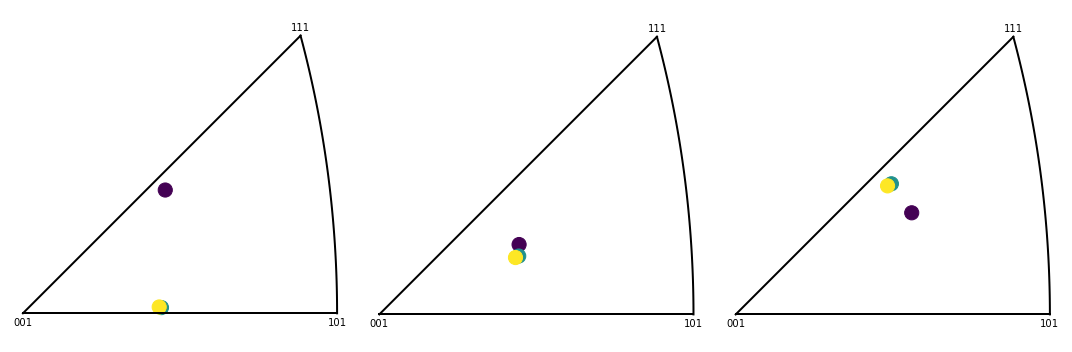

In [9]:
size = 200
quats = [q1, q2, q3]
colours = [1, 2, 3] # viridis scale so 1 is blue, 2 is greenish and 2 is yellow

fig, axes = plt.subplots(1,3, figsize=(15,5))

Quat.plotIPF(quats, np.array([1,0,0]), "cubic", marker='o', s=size, c=colours, fig=fig, ax=axes[0])
Quat.plotIPF(quats, np.array([0,1,0]), "cubic", marker='o', s=size, c=colours, fig=fig, ax=axes[1])
Quat.plotIPF(quats, np.array([0,0,1]), "cubic", marker='o', s=size, c=colours, fig=fig, ax=axes[2])

plt.tight_layout()

## Calculate symmetrically equivalent orientations

In [10]:
for symm in Quat.symEqv('cubic'):
    symQuat = symm * q1
    
    symEulers = symQuat.eulerAngles()*180/np.pi
    print(round(symEulers[0], 1), '\t', round(symEulers[1], 1), '\t', round(symEulers[2], 1))

45.0 	 30.0 	 30.0
258.7 	 64.3 	 163.9
225.0 	 150.0 	 150.0
78.7 	 115.7 	 16.1
341.6 	 104.5 	 63.4
225.0 	 150.0 	 330.0
161.6 	 75.5 	 296.6
45.0 	 30.0 	 300.0
45.0 	 30.0 	 210.0
45.0 	 30.0 	 120.0
225.0 	 150.0 	 60.0
225.0 	 150.0 	 240.0
161.6 	 75.5 	 116.6
341.6 	 104.5 	 243.4
258.7 	 64.3 	 343.9
78.7 	 115.7 	 196.1
258.7 	 64.3 	 73.9
161.6 	 75.5 	 26.6
341.6 	 104.5 	 333.4
258.7 	 64.3 	 253.9
161.6 	 75.5 	 206.6
78.7 	 115.7 	 106.1
341.6 	 104.5 	 153.4
78.7 	 115.7 	 286.1


## Calculate a possible twin orientation
An FFC annealing twin is a 60 deg rotation around a [111] crystal direction

In [11]:
axis = np.array([1.,1.,1.])
angle = np.pi/3

parentOri = q1
twinTransform = Quat.fromAxisAngle(axis, angle)

twinOri = twinTransform * parentOri

In [12]:
misori = 2 * np.arccos(parentOri.misOri(twinOri, 'cubic'))
misoriAxis = parentOri.misOriAxis(twinOri)

print(round(misori*180/np.pi, 1), 'deg')
print(misoriAxis)

60.0 deg
[0.60459979 0.60459979 0.60459979]


## Mean orientaion 
Demonstrate with some EBSD data

In [13]:
# Load in EBSD map, detect grains and calculate grain average orientations
# This data is available in defdap's github repo
ebsdFilePath = "./testDataEBSD"
crystalSymmetry = "cubic"

ebsdMap = ebsd.Map(ebsdFilePath, "cubic")
ebsdMap.loadSlipSystems("./cubic_fcc.txt")
ebsdMap.buildQuatArray()

ebsdMap.findBoundaries(boundDef=8)
ebsdMap.findGrains(minGrainSize=10)
ebsdMap.calcGrainAvOris()

Loaded EBSD data (dimensions: 359 x 243 pixels, step size: 0.12 um)
Finished building quaternion array           
Finished finding grain boundaries           
Finished finding grains           
Finished calculating grain mean orientations           


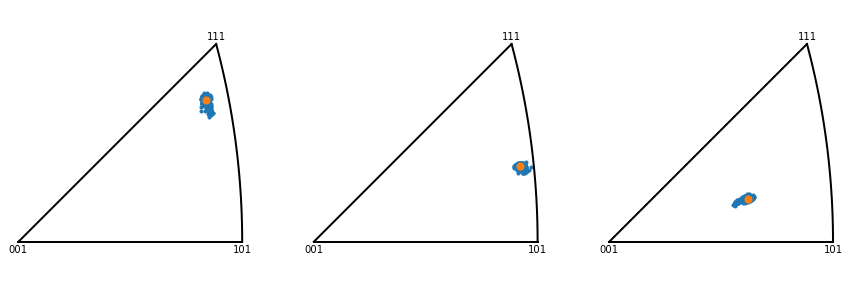

In [14]:
grain = ebsdMap[18]
size = 50

fig, axes = plt.subplots(1,3, figsize=(15,5))

plot = grain.plotOriSpread(np.array([1,0,0]), fig=fig, ax=axes[0])
grain.plotRefOri(np.array([1,0,0]), marker='o', s=size, plot=plot)

plot = grain.plotOriSpread(np.array([0,1,0]), fig=fig, ax=axes[1])
grain.plotRefOri(np.array([0,1,0]), marker='o', s=size, plot=plot)

plot = grain.plotOriSpread(np.array([0,0,1]), fig=fig, ax=axes[2])
grain.plotRefOri(np.array([0,0,1]), marker='o', s=size, plot=plot)

## Calculate components of slip direction in sample coordinates
Only for cubic crystals. For hexagonal crystals you have to transform to an orthonormal coordinate system in the crystal first (See pg 22 of Randle and Engle - Introduction to texture analysis)

In [15]:
slipDir = np.array([0,1,1])

slipDirQuat = Quat(0, slipDir[0], slipDir[1], slipDir[2])
slipDirSampleQuat = q1.conjugate * (slipDirQuat * q1)
slipDirSample = slipDirSampleQuat.quatCoef[1:4]

print(slipDirSample)

[-0.53033009 -0.1767767   1.29903811]


In [16]:
# or use method in the quat object

slipDirSample = q1.conjugate.transformVector(slipDir)

print(slipDirSample)

[-0.53033009 -0.1767767   1.29903811]
